# Foundations of Explainable AI and Applications to AutoML: Hands-On

In [29]:
import numpy as np
from utils.dataset import Dataset
from sklearn import ensemble
from utils.styled_plot import plt
import itertools


# Create a dataset
dataset = Dataset(
    "wheat_seeds",
    input_ids=[0,1,3,4,5,6],
    output_ids=[2],
    normalize=True,
    categorical=False,
)
(X_train, y_train), (X_test, y_test) = dataset.get_data()

print("Number of wheat seeds (train):", X_train.shape[0])
print("Number of wheat seeds (test):", X_test.shape[0])
print("Input labels:", dataset.get_input_labels())
print("Output labels:", dataset.get_output_labels())

# Create a model
model = ensemble.RandomForestRegressor(n_estimators=200, random_state=0)
model = model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Number of wheat seeds (train): 159
Number of wheat seeds (test): 40
Input labels: ['area' 'perimeter' 'length' 'width' 'asymmetry' 'groove']
Output labels: compactness
Train accuracy: 0.9821647709998096
Test accuracy: 0.8737789546578139


## Individual Conditional Expectation (ICE)

![Image](images/ice.png)

In [30]:
def calculate_ice(model, X, s):
    """
    Takes the input data and expands the dimensions from (num_instances, num_features) to (num_instances,
    num_instances, num_features). For the current instance i and the selected feature index s, the
    following equation is ensured: X_ice[i, :, s] == X[i, s].
    
    Parameters:
        model: Classifier which can call a predict method.
        X (np.array with shape (num_instances, num_features)): Input data.
        s (int): Index of the feature x_s.
        
    Returns:
        X_ice (np.array with shape (num_instances, num_instances, num_features)): Changed input data w.r.t. x_s.
        y_ice (np.array with shape (num_instances, num_instances)): Predicted data.
    """

    shape = X.shape
    X_ice = np.zeros((shape[0], *shape))
    y_ice = np.zeros((shape[0], shape[0]))

    # Iterate over data points
    for i in range(X.shape[0]):
        X_copy = X.copy()
        
        # Intervention
        # Take the value of i-th data point and set it to all others
        # We basically fix the value
        X_copy[:, s] = X_copy[i, s]
        X_ice[i] = X_copy
        
        # Then we do a prediction with the new data
        y_ice[i] = model.predict(X_copy)
        
    return X_ice, y_ice

X_ice, y_ice = calculate_ice(model, dataset.X, s=3)

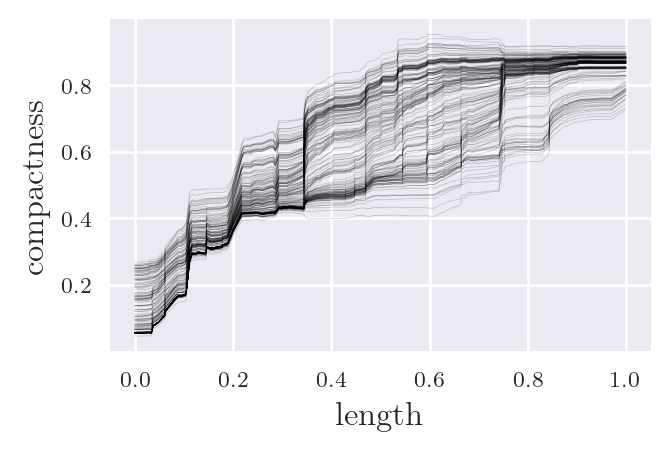

In [31]:
def plot_ice(model, dataset, X, s, centered=False):
    """
    Creates a plot object and fills it with the content of `calculate_ice`.
    Note: `show` method is not called.
    
    Parameters:
        model: Classifier which can call a predict method.
        dataset (utils.Dataset): Used dataset to train the model. Used to receive the labels.
        s (int): Index of the feature x_s.
        centered (bool): Whether c-ICE should be used or not.
        
    Returns: 
        plt (matplotlib.pyplot or utils.styled_plot.plt)
    """
    
    plt.figure()
    plt.xlabel(dataset.get_input_labels(s))
    plt.ylabel(dataset.get_output_labels())
    
    # Calculate the ICE data
    X_ice, y_ice = calculate_ice(model, X, s)

    for i in range(X.shape[0]):
        x = X_ice[:, i, s]
        y = y_ice[:, i]
            
        # We have to sort x because they might be not
        # in the right order
        idx = np.argsort(x)
        x = x[idx]
        y = y[idx]
            
        # Or all zero centered (c-ICE)
        if centered:
            y = y - y[0]
        
        plt.plot(x, y, linewidth=0.25, alpha=0.2, color="black")
        
    return plt

plt = plot_ice(model, dataset, dataset.X, 3, centered=False)
plt.show()

## Partial Dependency Plots (PDP)

In [32]:
def calculate_pdp(model, X, s):
    """
    Uses `calculate_ice` to retrieve plot data for PDP.
    
    Parameters:
        model: Classifier which can call a predict method.
        X (np.ndarray with shape (num_instances, num_features)): Input data.
        s (int): Index of the feature x_s.
        
    Returns:
        x (list or 1D np.ndarray): x values of the PDP line.
        y (list or 1D np.ndarray): y values of the PDP line.
    """
    
    _, y_ice = calculate_ice(model, X, s)
        
    # Take all x_s instance value
    x = X[:, s]
    # Alternatively use X_ice directly
    # x = X_ice[:, 0, s]
    
    y = []
    # Simply take all values and mean them
    for i in range(y_ice.shape[0]):
        y.append(np.mean(y_ice[i, :]))
            
    y = np.array(y)
        
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    
    return x, y

x_pdp, y_pdp = calculate_pdp(model, dataset.X, s=3)

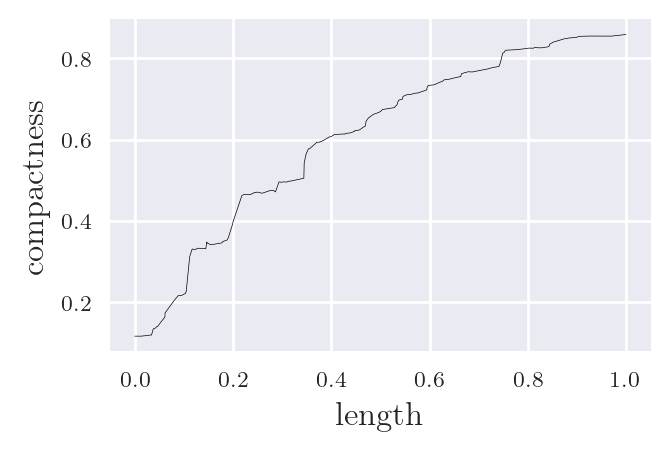

In [33]:
def plot_pdp(model, dataset, X, s):
    """
    Creates a plot object and fills it with the content of `calculate_pdp`.
    Note: `show` method is not called.
    
    Parameters:
        model: Classifier which can call a predict method.
        dataset (utils.Dataset): Used dataset to train the model. Used to receive the labels.
        s (int): Index of the feature x_s.
        centered (bool): Whether c-ICE should be used or not.
        
    Returns: 
        plt (matplotlib.pyplot or utils.styled_plot.plt)
    """
    
    x, y = calculate_pdp(model, X, s)
    
    plt.figure()
    plt.xlabel(dataset.get_input_labels(s))
    plt.ylabel(dataset.get_output_labels())

    # Now do the plotting
    plt.plot(x, y, linewidth=0.25, alpha=1, color="black")
        
    return plt

plt = plot_pdp(model, dataset, dataset.X, 3)
plt.show()

## Shapley

In [34]:
def merge(a, b, j):
    """
    Merges elements a and b s.t. two new arrays are created.
    Elements before position j will be from a, whereas elements after position j will be from b.

    Parameters:
        a (np.ndarray): Numpy array with shape (?,)
        b (np.ndarray): Numpy array with shape (?,)
        j (int): Index of the feature.

    Returns:
        plus_j (np.ndarray): Element from a at the position j. Same shape as a or b.
        minus_j (np.ndarray): Element from b at the position j. Same shape as a or b.
    """
    plus_j = []
    minus_j = []

    for i, (a_, b_) in enumerate(zip(a, b)):
        if i < j:
            # Head
            plus_j.append(a_)
            minus_j.append(a_)
        elif i == j:
            # Middle
            plus_j.append(a_)
            minus_j.append(b_)
        else:
            # Tail
            plus_j.append(b_)
            minus_j.append(b_)

    plus_j = np.array(plus_j)
    minus_j = np.array(minus_j)

    return plus_j, minus_j


a = [0, 1, 2, 3, 4, 5, 6]
b = ["A", "B", "C", "D", "E", "F", "G"]
j = 2

plus_j, minus_j = merge(a, b, j)
print(plus_j, minus_j)

['0' '1' '2' 'D' 'E' 'F' 'G'] ['0' '1' 'C' 'D' 'E' 'F' 'G']


In [35]:
def get_shapley_by_estimation(model, X, x, j, M=None, seed=0):
    """
    Calculates the shapley value by estimation.

    Parameters:
        X (np.ndarray): Data from which z is sampled from.
        x: Instance of interest.
        j (int): Feature index. Starts from 0.
        M (int): Number of sampling iterations.
        seed (int): Seed for numpy.

    Returns:
        value (float): Shapley value.
    """
    np.random.seed(seed)

    if M is None:
        M = len(X)

    if M == 0:
        return 0

    # How many features do we have
    p = len(x)

    value = 0
    for z_id in np.random.choice(len(X), M):
        # Select permutation (get ids) to shuffle the features
        # Important compare different model predictions
        pi = np.random.permutation(p)
        inverse_pi = np.argsort(pi)

        # Draw random instance from X
        z = X[z_id]

        # Permutate both x and z
        x_perm = x[pi]
        z_perm = z[pi]

        # Create two new instances
        x_plus_j, x_minus_j = merge(x_perm, z_perm, j)

        # Now we have to permutate back
        x_plus_j = x_plus_j[inverse_pi]
        x_minus_j = x_minus_j[inverse_pi]

        # Calculate difference
        phi = model.predict(np.array([x_plus_j])) - model.predict(np.array([x_minus_j]))
        value += float(phi)

    # And divide by number of samples
    value /= M
    
    return value


for x in dataset.X[:3]:
    print(f"\nInstance {x}")
    print(f"Prediction of the {dataset.get_output_labels()}: {model.predict([x])[0]}")
    print("Shapley values:")
    for j, label in enumerate(dataset.get_input_labels()):
        value = get_shapley_by_estimation(model, X_train, x, j)
        print(f"--- {label}: {value}")


Instance [0.44098206 0.50206612 0.48648649 0.48610121 0.19283699 0.34515017]
Prediction of the compactness: 0.5882214156079837
Shapley values:
--- area: -0.004205332785444394
--- perimeter: 0.019640362291545296
--- length: 0.0010221552580213064
--- width: -0.005225747354724028
--- asymmetry: 0.006436524786265853
--- groove: -0.014459986987638734

Instance [0.40509915 0.44628099 0.36880631 0.50106914 0.03349713 0.21516494]
Prediction of the compactness: 0.6829627949183285
Shapley values:
--- area: 0.00454502391306831
--- perimeter: 0.0331965893915008
--- length: 0.01616563366777375
--- width: 0.011991233777351463
--- asymmetry: 0.026740745813785813
--- groove: 0.005310127954889878

Instance [0.34938621 0.34710744 0.22072072 0.50392017 0.25614909 0.1506647 ]
Prediction of the compactness: 0.8500998185117968
Shapley values:
--- area: 0.015526886507094096
--- perimeter: 0.049798137177687225
--- length: 0.039742948783800774
--- width: 0.03771547443755787
--- asymmetry: 0.06909255898366622
